In [1]:
# import HybridNet # 要先运行4、HybridNet.py
import torch
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import math
import time
import os

dtype = torch.float
device_data = torch.device("cpu")
device_train = torch.device("cuda:0")
device_test = torch.device("cuda:0")

TrainingDataSize = 12000000 # 像素总共有(14183255, 31)
TestingDataSize = 2000000
BatchSize = 10000 # 可以更大些,原来2k
EpochNum = 20*4*4 #20要1600s
TestInterval = 1*2
lr = 1e-4
#lr_decay_step = 1000 # 可以考虑视下降快慢进行调节，而不是阶梯式
#lr_decay_gamma = 0.8

StartWL = 400
EndWL = 701
Resolution = 10
WL = np.arange(StartWL, EndWL, Resolution) # nm
SpectralSliceNum = WL.size

#path_data = 'ICVL-pixel数据/no_selected_pixellm_true.mat'# 根目录
path_data = 'ICVL-pixel数据/no_selected_pixel_W_onlyICVL.mat'# 根目录

# 
data = scio.loadmat(path_data)

Specs_all = np.array(data['data']) # 
print(Specs_all.max(),Specs_all.min())
print(Specs_all.shape)
split_num = Specs_all.shape[0]//TestingDataSize # 等间隔获取像素
test_idx_selected = np.arange(0,Specs_all.shape[0],split_num)
np.random.seed(5)
random_1 = np.floor(np.random.rand(test_idx_selected.shape[0])*2-1).astype(np.int16) # 随机生成-1 0 1
random_1[0]=0
random_1[-1]=0
test_idx_selected = test_idx_selected+random_1
#print(test_idx_selected.shape)
#np.random.shuffle(Specs_all)



#print(Specs_filter,Specs_filter.shape) # [31,1]
#print(Specs_all.shape,split_num,test_idx_selected.shape,random_1.shape)
#print(test_idx_selected.min(),test_idx_selected.max())
all_idx = np.arange(0,Specs_all.shape[0],1)
#差集
train_idx_selected = list(set(all_idx).difference(set(test_idx_selected))) # 剩下的像素作为训练集
train_idx_selected=np.array(train_idx_selected)
#print(train_idx_selected.shape,train_idx_selected.max(),train_idx_selected.min())

# 为训练和测试的example的重构光谱分配cpu中内存空间
Specs_train = torch.zeros([Specs_all.shape[0]-test_idx_selected.shape[0], SpectralSliceNum], device=device_data, dtype=dtype)
Specs_train[0:(Specs_all.shape[0]-test_idx_selected.shape[0]), :] = torch.tensor(Specs_all[train_idx_selected, :])
Specs_test = torch.zeros([test_idx_selected.shape[0], SpectralSliceNum], device=device_data, dtype=dtype)
Specs_test[0:test_idx_selected.shape[0], :] = torch.tensor(
    Specs_all[test_idx_selected, :])
#print(Specs_all.max(),(np.dot(Specs_all,filter_data/2**16)).max())# 1.0 0.9819639649967188
# 关闭并清理缓存
del Specs_all, data
assert SpectralSliceNum == Specs_train.size(1)

26.918409984374996 0.6676685963645834
(15131836, 31)


# --------------------------------------------------------
# HybridNet.py
## 为SED模型自定义一个网络类
- 用functional运行赋予权重的FC层，w用量子效率QE、曝光时间t、ADC放大系数K表示，实现入射光调制过程
- 用新的网络完成调制后y到重构s的学习

## 损失类
- 第一组成部分：MRAE


import torch
import numpy as np
torch.__version__

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as func # 与nn.Module类似，但有区别，在于其声明的layer是没有可训练参数的


class HybridNet(nn.Module): # 继承nn.Module
    # 初始化所需参数：CCDQE,PCSED网络层数/数组,网络计算设备/字符串
    def __init__(self,T_min, T_max,K,tc,h_p,c_light,pixel_S,WL,filter_data,size, device):
        # 利用父类初始化函数进行初始化
        super(HybridNet, self).__init__() 

        #self.tf_layer_num = self.fnet.state_dict()['0.weight'].data.size(1) # 这里返回FMN第一层（FC）的输入神经元个数=10
        # ？---------------------一个数组，储存着结构变量的上下界
        self.DesignParams = nn.Parameter(
            (T_max - T_min) * torch.rand([size[0], size[1]]) + T_min, requires_grad=True)  #  31 x n片滤波片
            # 这个是BEST-F的结构训练变量          BEST-Fs数量size[1],一个BEST-F含传输率数目31，生成这么多组随机值，相当于一个初始化
        #print('self.DesignParams.shape'+str(self.DesignParams.shape))
        # ---------------------------
       
        # 相机参数部分
        self.filter = filter_data
        #print('self.filter.shape'+str(self.filter.shape))
        self.WL = torch.tensor(WL).reshape(WL.size,1).to(device)
        #print('self.WL.shape'+str(self.WL.shape))
        #print(self.WL.shape,self.filter.shape)
        self.CCD_filter = self.filter*self.WL
        #print('self.CCD_filter.shape'+str(self.CCD_filter.shape))
        self.parm=tc*pixel_S/h_p/c_light/K
        #print('self.parm'+str(self.parm))
        # 开始构建PCSED的网络
        self.SWNet = nn.Sequential()
        self.SWNet.add_module('BatchNorm0', nn.BatchNorm1d(size[1]))
        #self.SWNet.add_module('LReLU0', nn.LeakyReLU(inplace=True)) # 为SWNet添加名为'LReLU0'的激活层
        self.SWNet.add_module('PRelu0',nn.PReLU(num_parameters=size[1], init=0.01))
        for i in range(1, len(size) - 1): # 除了第一层激活层外，建立多个相同的层block，由一层FC和一层LR组成
            self.SWNet.add_module('Linear' + str(i), nn.Linear(size[i], size[i + 1])) # 输入神经元为size[i]，输出神经元为size[i+1]
            self.SWNet.add_module('BatchNorm' + str(i), nn.BatchNorm1d(size[i+1]))
            #self.SWNet.add_module('DropOut' + str(i), nn.Dropout(p=0.1)) # 由于断点续训后过拟合了
            #self.SWNet.add_module('LReLU' + str(i), nn.LeakyReLU(inplace=True))
            self.SWNet.add_module('PRelu' + str(i),nn.PReLU(num_parameters=size[i+1], init=0.01))
        #self.SWNet.add_module('Sigmoid_end' ,nn.Sigmoid())
        self.to(device) # 将本网络也送入device对应的设备

    # 正向传播，用nn.functional里的无需训练的FC层（权重由filter读取），实现光入射调制
    # 只输入入射光谱的完整传播，是重写module的函数
    def forward(self, data_input,device): 
        #FMN =self.fnet(self.DesignParams).t()# 从p到w   4*10-》4*31 转置31*4
        #print('FMN.shape'+str(FMN.shape))
        all_W =torch.mul(self.DesignParams,self.CCD_filter.to(device)) # 31*4 点乘 31*4 =31*4  w和QE结合
        all_W = all_W.type(torch.float)
        #print('all_W.shape'+str(all_W.shape))
        output = data_input*self.parm # n*31 # 假设4个滤波片各占一个像素，像素光强不变
        #print('output_param.shape'+str(output.shape))
        output = output.type(torch.float)
        output = torch.matmul(output,all_W)# n*31 矩阵乘 31*4 = n*4 得到调制结果，
        #print('output_matmul.shape'+str(output.shape))
        output = self.SWNet(output) # n*4 net n*31 从低纬度到高纬度
        #print('outputSWNet.shape'+str(output.shape))
        #output = torch.divide(output.transpose(1,0),all_W) # 这里忽略这个调制系数，因为只有一两个量级的影响
        output = output/self.parm #n*31 
        return output
        #                                        
    # 步骤拆分
    def return_all_W(self):
        return torch.mul(self.DesignParams,self.CCD_filter.to(device))
    def run_outCamera(self,rawdata):
        output = self.SWNet(rawdata) # 从低纬度到高纬度
        output = output/self.parm
        return output         
    def show_parameter(self):
        return self.filter,self.WL,self.CCD_filter,self.parm
    def show_BESTFs_T(self):
        return self.DesignParams
MatchLossFcn = nn.MSELoss(reduction='mean') # 这个MSE是用来表征重构s和输入s差距的，(x-x')**2/num
# 自定义损失函数，是MRAE误差，是用来训练PCSED的
class MRAELoss(nn.Module):
    def __init__(self):
        super(MRAELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))
        
        #mrae = MatchLossFcn(t1,t2)
        return mrae
class HybnetLoss(nn.Module):
    def __init__(self):
        super(HybnetLoss, self).__init__()

    def forward(self, t1, t2, params, T_min, T_max, beta_range,T_beta):
        # MARE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))

        # 传输率要再0-1之间
        # U-shaped function，U([param_min + delta, param_max - delta]) = 0, U(param_min) = U(param_max) = 1。
        delta = 0.01
        res = torch.max((params - T_min - delta) / (-delta), (params - T_max + delta) / delta)
        range_loss = torch.mean(torch.max(res, torch.zeros_like(res)))
        #print(mrae,range_loss)
        
        # 传输率的峰谷数目限制
        one_diff = torch.diff(params, dim=0)
        dtype = torch.float
        device = torch.device("cuda:0")
        ones_tensor = torch.ones((1,params.shape[1]),device=device,dtype=dtype)
        zeros_tensor = torch.zeros((1,params.shape[1]),device=device,dtype=dtype)
        
        absolute_loss= one_diff # goal = 0.2 抖动小，去掉绝对值
        sum_loss= torch.sum(one_diff,dim=0)   # goal = 0 左右对称
        variance_loss= torch.var(params, dim=0, unbiased=False) # goal = 0.16 幅值范围大
        mean_loss= torch.mean(params,dim=0) # goal = 0.3  峰的个数少
          
        l_mean = MatchLossFcn(ones_tensor*0.3,mean_loss)
        l_variance = MatchLossFcn(ones_tensor*0.16,variance_loss)
        l_absolute = MatchLossFcn(torch.zeros((absolute_loss.shape[0],absolute_loss.shape[1]),device=device,dtype=dtype),absolute_loss) # 这里设置为0.2的话，会反复震荡
        l_sum_loss = MatchLossFcn(zeros_tensor,sum_loss)
        T_loss = l_mean+l_variance+0.5*l_absolute+l_sum_loss
        
        return mrae + beta_range * range_loss  + T_beta*T_loss


## 新惩罚函数理念
# 1、一阶差分的数值尽量小  # 突变考虑
# 2、一阶差分和尽量小 # 左右对称考虑
# 3、原传输率平均值和方差尽量接近0.25 # 避免传输率为水平直线，避免整体幅度过大或过小




import torch
import numpy as np
torch.__version__
torch.manual_seed(0)

x= torch.rand((5,2),requires_grad=True)
print('x:',x)
one_diff = torch.diff(x, dim=0)
one_diff.retain_grad()
print('one_diff:',one_diff) # 可以反向传播


## 对一阶导数的限制
absolute_loss= one_diff # 一阶差分的偏差绝对值小，保证若是上升或下降不会很激烈
# 算出(所有滤波片的所有波段)平均的一阶导，按理说是一个区间都行，我这里用目标0.2
absolute_loss.retain_grad()
print('absolute_loss:',absolute_loss) 

sum_loss= torch.sum(one_diff,dim=0) # 增加的幅度和减小的幅度加和在0左右,
# 每个滤波片的各波段一阶导加绝对值的平均值 越接近0越好
sum_loss.retain_grad()
print('sum_loss:',sum_loss) 

## 对传输率数值分布的限制
variance_loss= torch.var(x, dim=0, unbiased=False)# 方差要在0.25左右，保证传输率函数跨度大，最好涵盖0-1
# 每个滤波片传输曲线的方差的平均值 越接近0.25越好 这意味着标准差为0.5
variance_loss.retain_grad()
print('variance_loss:',variance_loss) 

mean_loss= torch.mean(x,dim=0) # 平均值要在0.25左右
# 每个滤波片传输曲线的平均值的平均值 越接近0.25越好，因为传统滤波片的带通一般集中在可见光波段1/3区域，很难达到大范围带通
mean_loss.retain_grad()
print('mean_loss:',mean_loss) 

loss = torch.nn.MSELoss(reduction='mean')
one_tensor = torch.ones((1,x.shape[1]))
zero_tensor = torch.zeros((1,x.shape[1]))
print(one_tensor,zero_tensor)

l_mean = loss(one_tensor*0.35,mean_loss)
l_variance = loss(one_tensor*0.16,variance_loss)
l_absolute = loss(torch.zeros((absolute_loss.shape[0],absolute_loss.shape[1])),absolute_loss)
l_sum_loss = loss(zero_tensor,sum_loss)
all_loss = l_mean+l_variance+0.5*l_absolute+l_sum_loss
print('all_loss:',all_loss)
all_loss.backward()

print('all_loss.grad:',all_loss.grad)
print('absolute_loss.grad:',absolute_loss.grad)
print('sum_loss.grad:',sum_loss.grad)

print('variance_loss.grad:',variance_loss.grad)
print('mean_loss.grad:',mean_loss.grad)
print('one_diff.grad:',one_diff.grad)
print('x.grad:',x.grad)



loss = HybnetLoss()
t2 = Specs_train[:1,:5]
t1 = torch.add(t2,0.01)
mrae = loss(t1,t2)
print(t2)
print(t1)
print(mrae)
tensor([[0.3331, 0.3331, 0.3331, 0.3350, 0.3589]])
tensor([[0.3431, 0.3431, 0.3431, 0.3450, 0.3689]])
tensor(0.0296)

In [3]:
print(SpectralSliceNum,Specs_train.shape,Specs_test.shape,Specs_train[0,0:3]) #31 torch.Size([12587020, 31]) torch.Size([3146756, 31]) tensor(119.1875)
#lr = 1e-4

31 torch.Size([12970145, 31]) torch.Size([2161691, 31]) tensor([1.2135, 1.1024, 1.0017])


In [4]:
# 训练前准备工作诺
from __future__ import division 
# 把下一个新版本的特性导入到当前版本，于是我们就可以在当前版本中测试一些新版本的特性。
# 如果你的python版本是python2.X，你也得按照python3.X那样使用这些函数。




In [5]:
# PCSED的网络每层神经元个数，31进，经过1个CCD探测器（光谱响应） 调制，再经过重构输出重构光谱31
TFNum=16 # 一个阵列的探测器/滤波片数目
K=200 # e-/DN
tc=10**-3 # s 1ms
h_p=6.626*10**-17 # *10**-17J/s
c_light = 3 # 10**8m/s
pixel_S= 6*6*10**-12 # m**2

T_beta = 0.4

filter_path = 'data/Camera spectral response function/CinCCD_QE_splrep.mat' # 
filter_data = scio.loadmat(filter_path)['filters']
beta_range = 2*1e-3 # 结构参数p正则化惩罚的系数 
mid_layer = 600 # 4层500，200epoch要40s。
hybnet_size = [SpectralSliceNum, TFNum, mid_layer,mid_layer//2,mid_layer//6, SpectralSliceNum]  
print(hybnet_size)

folder_name = time.strftime("%Y%m%d_%H%M%S_W_onlyICVL_newNETandLoss_newTbeta", time.localtime())
path = 'nets/hybnet/n+BEST-Fs_CinCCD/' + folder_name + '_TFNum=%d/'%(TFNum)
#file_name = '20210722_154226_W_onlyICVL_newNETandLoss_newTbeta_TFNum=16'
#path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
## 传输率上下限
T_min = torch.tensor([0])
T_max = torch.tensor([1])
    
Specs_filter = torch.zeros([filter_data.shape[0], TFNum], device=device_train, dtype=dtype)
Specs_filter =Specs_filter+ torch.tensor(filter_data).to(device_train)
#Specs_filter = torch.tensor(filter_data).to(device_train) # 原来是加Specs_filter = 原来是加Specs_filter+torch.tensor(filter_data).to(device_train)
#print(Specs_filter)
del filter_data,filter_path

[31, 16, 600, 300, 100, 31]


In [6]:
print(beta_range,T_beta)

0.002 0.4


In [7]:
print(T_min, T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train)

tensor([0]) tensor([1]) 200 0.001 6.626e-17 3 3.6e-11 [400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570
 580 590 600 610 620 630 640 650 660 670 680 690 700] tensor([[0.2863, 0.2863, 0.2863, 0.2863, 0.2863, 0.2863, 0.2863, 0.2863, 0.2863,
         0.2863, 0.2863, 0.2863, 0.2863, 0.2863, 0.2863, 0.2863],
        [0.3193, 0.3193, 0.3193, 0.3193, 0.3193, 0.3193, 0.3193, 0.3193, 0.3193,
         0.3193, 0.3193, 0.3193, 0.3193, 0.3193, 0.3193, 0.3193],
        [0.3635, 0.3635, 0.3635, 0.3635, 0.3635, 0.3635, 0.3635, 0.3635, 0.3635,
         0.3635, 0.3635, 0.3635, 0.3635, 0.3635, 0.3635, 0.3635],
        [0.4051, 0.4051, 0.4051, 0.4051, 0.4051, 0.4051, 0.4051, 0.4051, 0.4051,
         0.4051, 0.4051, 0.4051, 0.4051, 0.4051, 0.4051, 0.4051],
        [0.4509, 0.4509, 0.4509, 0.4509, 0.4509, 0.4509, 0.4509, 0.4509, 0.4509,
         0.4509, 0.4509, 0.4509, 0.4509, 0.4509, 0.4509, 0.4509],
        [0.4841, 0.4841, 0.4841, 0.4841, 0.4841, 0.4841, 0.4841, 0.4841, 0.4841,
   

In [8]:
# 自定义网络类实例化，将FMN网络，参数上下限，PCSED网络层数等参数输入，并构建对象
hybnet = HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
#hybnet.eval()

checkpoint = torch.load(path+'HybridNet_epoch=292_flag=train_loss=0.020.pkl')
hybnet.load_state_dict(checkpoint['state_dict'])# 模型参数读取
hybnet.to(device_train)
hybnet.eval()

import matplotlib.pyplot as plt
Loss_final = MRAELoss()
train_idx= 2000000
Output_train = hybnet(Specs_train[train_idx, :].reshape(1,-1).to(device_test),device_test)# 拿第一个像素的光谱测试一下
FigureTrainLoss = Loss_final(Output_train,Specs_train[train_idx, :].to(device_test) )
plt.figure()
plt.plot(WL, Specs_train[train_idx, :].cpu().numpy())
plt.plot(WL, Output_train.detach().cpu().numpy().reshape(-1))
plt.legend(['in','out'])
print(FigureTrainLoss)
Loss_final = HybnetLoss()
train_idx= 8000
DesignParams = hybnet.show_BESTFs()
plt.figure()
plt.plot(WL,hybnet.run_FMN().detach().cpu())
Output_train = hybnet(Specs_train[train_idx, :].reshape(1,-1).to(device_test),device_test)# 拿第一个像素的光谱测试一下
FigureTrainLoss = Loss_final(Output_train,Specs_train[train_idx, :].to(device_test),DesignParams, thick_min.to(device_train), thick_max.to(device_train), beta_range )
plt.figure()
plt.plot(WL, Specs_train[train_idx, :].cpu().numpy())
plt.plot(WL, Output_train.detach().cpu().numpy().reshape(-1))
print(FigureTrainLoss)
plt.legend(['in','out'])

filter1,WL1,CCD_filter1,parm1=hybnet.show_parameter()

print(parm1)
mid_value = hybnet.run_matmul(Specs_train[0:2,:].to(device_train),device_train)
#hybnet.forward(Specs_train[0:2,:].to(device_train),device_train)
print(mid_value)
print(hybnet.run_SWNet(mid_value).transpose(1,0).shape)
print(torch.divide(hybnet.run_SWNet(mid_value).transpose(1,0),CCD_filter1)/parm1)
#print(torch.matmul(Specs_train[0:2,:].to(device_train)*parm1,CCD_filter1))

In [9]:

# Learning rate
def poly_lr_scheduler(optimizer, init_lr, iteraion, lr_decay_iter=1,
                      max_iter=100, power=0.9):
    """Polynomial decay of learning rate
        :param init_lr is base learning rate
        :param iter is a current iteration
        :param lr_decay_iter how frequently decay occurs, default is 1
        :param max_iter is number of maximum iterations
        :param power is a polymomial power 幂次

    """
    if iteraion % lr_decay_iter or iteraion > max_iter:
        # 如果iteration非整数，或超出max_iter，则
        return optimizer

    lr = init_lr*(1 - iteraion/max_iter)**power # 初始学习率*（1-迭代次数/最大迭代次数）的power次幂
    for param_group in optimizer.param_groups:# 遍历optimizer中的各个卷积层的学习率进行更新
        param_group['lr'] = lr
    return lr

In [10]:
# 自定义损失类实例化
LossFcn = HybnetLoss() # 这个是误差传播用的
# 优化器，只针对hybnet.parameters()中.requires_grad为True的参数
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, hybnet.parameters()), lr=lr,betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# 学习率更新器
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
# 存储每次epoch后的模型指标mare

In [11]:
# 自定义 保存模型检查点 函数，保存路径，当前训练的epoch，当前训练的iteration，模型，优化器
def save_checkpoint(model_path, epoch, iteration, model, optimizer,record_loss):
    """Save the checkpoint."""
    state = {
            'epoch': epoch,
            'iter': iteration,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'record_loss':record_loss,
            }
    
    torch.save(state, os.path.join(model_path, 'HybridNet_epoch=%d_loss=%.3f.pkl' %(epoch,record_loss))) 
    # %()是一种对字符串的赋参方式，即%d会由epoch所替换    
def save_train_test_checkpoint(model_path, epoch, iteration, model, optimizer,record_loss,flag):
    """Save the checkpoint."""
    state = {
            'epoch': epoch,
            'iter': iteration,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'record_loss':record_loss,
            'flag':flag,
            }
    
    torch.save(state, os.path.join(model_path, 'HybridNet_epoch=%d_flag=%s_loss=%.3f.pkl' %(epoch,flag,record_loss)))
    # %()是一种对字符串的赋参方式，即%d会由epoch所替换

In [12]:
# 断电续训
# 读取模型
record_train =10
record_train_epoch = -1
record_test =10
record_test_epoch = -1
record_epoch=0
iteration =0 
record_loss = 10
os.makedirs(path, exist_ok=True)
pkl_file_path = path

for file in os.listdir(pkl_file_path):
    if file[-3:] =='pkl':
        # 默认没设置读取路径，若想读取，可以
        checkpoint = torch.load(pkl_file_path+file) # 读取checkpoint字典
        if file.find('flag')==-1:
            print("=> loading checkpoint '{}'".format(pkl_file_path))
            record_epoch = checkpoint['epoch'] # 为什么要保存已经进行的epoch和iteration?用过的数据不再用？
            iteration = checkpoint['iter']
            record_loss = checkpoint['record_loss']
            hybnet.load_state_dict(checkpoint['state_dict'])# 模型参数读取
            optimizer.load_state_dict(checkpoint['optimizer'])# 优化器参数读取        
        elif file.find('train')!=-1:
            record_train = checkpoint['record_loss']
            record_train_epoch = checkpoint['epoch']
        elif file.find('test')!=-1:
            record_test = checkpoint['record_loss']
            record_test_epoch = checkpoint['epoch']
        
print(optimizer)
print(record_loss,record_epoch,iteration,record_train,record_train_epoch,record_test,record_test_epoch)
print(hybnet)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
10 0 0 10 -1 10 -1
HybridNet(
  (SWNet): Sequential(
    (BatchNorm0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu0): PReLU(num_parameters=16)
    (Linear1): Linear(in_features=16, out_features=600, bias=True)
    (BatchNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu1): PReLU(num_parameters=600)
    (Linear2): Linear(in_features=600, out_features=300, bias=True)
    (BatchNorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu2): PReLU(num_parameters=300)
    (Linear3): Linear(in_features=300, out_features=100, bias=True)
    (BatchNorm3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu3): PReLU(num_parameters=100)
    (Linear4): Linear(in_features=100, out_features=31, bias=True)
   

In [13]:
#EpochNum = int(EpochNum*2)
#LossFcn = HybnetLoss() # 这个是误差传播用的
loss = torch.tensor([0], device=device_train)
loss_train = torch.zeros(math.ceil((EpochNum-record_epoch) // TestInterval))
loss_test = torch.zeros(math.ceil((EpochNum-record_epoch) // TestInterval))
Loss_final = MRAELoss() # 这个是计算MARE用的

In [14]:
print(record_epoch,EpochNum,iteration,lr)
#EpochNum=20*4*4*2 # 续训用
#iteration = 380400   176 320 212400 0.0001

0 320 0 0.0001


In [15]:
# 开始训练，计算时间
log_file = open(path + 'TrainingLog.txt', 'a+') # 续写
time_start = time.time()
time_epoch0 = time_start
record_epoch_start = record_epoch
for epoch in range(record_epoch_start,EpochNum):
    Specs_train = Specs_train[torch.randperm(TrainingDataSize), :] # 打乱
    for i in range(0, TrainingDataSize // BatchSize): # 分batch进行训练
        Specs_batch = Specs_train[i * BatchSize: i * BatchSize + BatchSize, :].to(device_train)
        Output_pred = hybnet(Specs_batch,device_train) # 正向传播结果，此时会调用重写的forward函数
        
        # 根据输入和输出的MSE+结构参数p的正则化惩罚计算loss
        DesignParams = hybnet.show_BESTFs_T()
        loss = LossFcn(Output_pred,Specs_batch, DesignParams, T_min.to(device_train), T_max.to(device_train), beta_range,T_beta)
        #loss = LossFcn(Output_pred,Specs_batch)
        # 优化器梯度清零
        optimizer.zero_grad()
        # 反向传播，保留图
        loss.backward(retain_graph=True)
        # 更新除了filter参数外的其他参数
        optimizer.step()
        iteration=iteration+1
    #scheduler.step() # 计数，当epoch是lr_decay_step的整数倍时，更新学习率
    new_lr = poly_lr_scheduler(optimizer, lr, iteration, max_iter=EpochNum*(TrainingDataSize // BatchSize)*1.2, power=1.2) 
    # 至此一个epoch的训练完成，若已完成TestInterval整数倍的epoch，则进行测试
    if epoch % TestInterval == 0:
        loss_train[(epoch-record_epoch_start) // TestInterval] = loss.data
        for i in range(0, Specs_test.shape[0] // BatchSize): 
            #hybnet.to(device_test)
            hybnet.eval()
            Specs_batch = Specs_test[i * BatchSize: i * BatchSize + BatchSize, :].to(device_test)
            Out_test_pred = hybnet(Specs_batch,device_test)# 测试集的正向传播
            #hybnet.to(device_train)
            hybnet.train()
            #hybnet.eval_fnet() # 这句很关键
            loss_t=Loss_final(Out_test_pred,Specs_batch)
            loss_test[(epoch-record_epoch_start) // TestInterval] =loss_test[(epoch-record_epoch_start) // TestInterval]+loss_t.data
        loss_test[(epoch-record_epoch_start) // TestInterval] = loss_test[(epoch-record_epoch_start) // TestInterval]/(Specs_test.shape[0] // BatchSize)
        
        #loss_test[epoch // TestInterval] = loss_t.data
        if record_train>loss.data:
            if os.path.exists(path+ 'HybridNet_epoch=%d_flag=%s_loss=%.3f.pkl'%(record_train_epoch,'train',record_train)):
                os.remove(path+ 'HybridNet_epoch=%d_flag=%s_loss=%.3f.pkl'%(record_train_epoch,'train',record_train))
            record_train_epoch = epoch
            record_train = loss.data
            save_train_test_checkpoint(path, record_train_epoch, iteration, hybnet, optimizer,loss.data,'train')
        if record_test>loss_t.data:
            if os.path.exists(path+ 'HybridNet_epoch=%d_flag=%s_loss=%.3f.pkl'%(record_test_epoch,'test',record_test)):
                os.remove(path+ 'HybridNet_epoch=%d_flag=%s_loss=%.3f.pkl'%(record_test_epoch,'test',record_test))
            record_test_epoch = epoch
            record_test = loss_t.data
            save_train_test_checkpoint(path, record_test_epoch, iteration, hybnet, optimizer,loss_t.data,'test')

        # Save model
        if loss_t.data+loss.data < record_loss*2: # 初值是1000，如果新的模型使得验证集loss变小，则存储模型
            if os.path.exists(path+ 'HybridNet_epoch=%d_loss=%.3f.pkl'%(record_epoch,record_loss)):
                os.remove(path+ 'HybridNet_epoch=%d_loss=%.3f.pkl'%(record_epoch,record_loss))
            record_epoch = epoch
            record_loss = (loss_t.data+loss.data)/2
            save_checkpoint(path, epoch, iteration, hybnet, optimizer,record_loss)
        if epoch == record_epoch_start:
            time_epoch0 = time.time()
            time_remain = (time_epoch0 - time_start) * EpochNum
        else:
            time_remain = (time.time() - time_epoch0) / (epoch-record_epoch_start) * (EpochNum - epoch+1)
        print('Epoch: ', epoch, '| train loss: %.5f' % loss.item(), '| test loss: %.5f' % loss_t.item(),
              '| learn rate: %.8f' % new_lr, '| remaining time: %.0fs (to %s)'
              % (time_remain, time.strftime('%H:%M:%S', time.localtime(time.time() + time_remain))))
        print('Epoch: ', epoch, '| train loss: %.5f' % loss.item(), '| test loss: %.5f' % loss_t.item(),
              '| learn rate: %.8f' % new_lr, file=log_file)# scheduler.get_last_lr()[0]

time_end = time.time()
time_total = time_end - time_start
m, s = divmod(time_total, 60)
h, m = divmod(m, 60)
print('Training time: %.0fs (%dh%02dm%02ds)' % (time_total, h, m, s))
print('Training time: %.0fs (%dh%02dm%02ds)' % (time_total, h, m, s), file=log_file)
# 
#Camera_response = hybnet.show_camera_weights().detach().cpu().numpy()# 获取

scio.savemat(path + 'camera_informations.mat', mdict={'QE': np.array(Specs_filter.cpu()),'TFnum':TFNum,'K':K,'tc':tc,'h':h_p,'c':c_light,'pixel_S':pixel_S,'hybnet_size':hybnet_size,'T_min':np.array(T_min),'T_max':np.array(T_max),'beta_range':beta_range,'T_beta':T_beta,'designed_TF_BESTFs':np.array(hybnet.show_BESTFs_T().detach().cpu())})
log_file.close()

E:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  0 | train loss: 0.60225 | test loss: 0.88411 | learn rate: 0.00009969 | remaining time: 7676s (to 18:27:39)
Epoch:  2 | train loss: 0.42600 | test loss: 0.75776 | learn rate: 0.00009906 | remaining time: 6263s (to 18:04:45)
Epoch:  4 | train loss: 0.29409 | test loss: 0.59626 | learn rate: 0.00009844 | remaining time: 6235s (to 18:04:57)
Epoch:  6 | train loss: 0.20169 | test loss: 0.42336 | learn rate: 0.00009782 | remaining time: 6203s (to 18:05:04)
Epoch:  8 | train loss: 0.13371 | test loss: 0.24578 | learn rate: 0.00009719 | remaining time: 6161s (to 18:05:02)
Epoch:  10 | train loss: 0.08538 | test loss: 0.12409 | learn rate: 0.00009657 | remaining time: 6116s (to 18:04:56)
Epoch:  12 | train loss: 0.05809 | test loss: 0.06927 | learn rate: 0.00009595 | remaining time: 6071s (to 18:04:50)
Epoch:  14 | train loss: 0.04937 | test loss: 0.04661 | learn rate: 0.00009533 | remaining time: 6040s (to 18:04:59)
Epoch:  16 | train loss: 0.04612 | test loss: 0.03206 | learn rate: 0

Epoch:  140 | train loss: 0.01617 | test loss: 0.01544 | learn rate: 0.00005775 | remaining time: 3610s (to 18:06:26)
Epoch:  142 | train loss: 0.02264 | test loss: 0.01371 | learn rate: 0.00005718 | remaining time: 3569s (to 18:06:24)
Epoch:  144 | train loss: 0.01989 | test loss: 0.01366 | learn rate: 0.00005661 | remaining time: 3529s (to 18:06:23)
Epoch:  146 | train loss: 0.01758 | test loss: 0.01298 | learn rate: 0.00005604 | remaining time: 3488s (to 18:06:22)
Epoch:  148 | train loss: 0.01506 | test loss: 0.01323 | learn rate: 0.00005547 | remaining time: 3448s (to 18:06:21)
Epoch:  150 | train loss: 0.01574 | test loss: 0.01325 | learn rate: 0.00005491 | remaining time: 3408s (to 18:06:20)
Epoch:  152 | train loss: 0.02042 | test loss: 0.01404 | learn rate: 0.00005434 | remaining time: 3367s (to 18:06:19)
Epoch:  154 | train loss: 0.01506 | test loss: 0.01563 | learn rate: 0.00005378 | remaining time: 3327s (to 18:06:18)
Epoch:  156 | train loss: 0.02232 | test loss: 0.01654 |

Epoch:  280 | train loss: 0.02045 | test loss: 0.01129 | learn rate: 0.00002062 | remaining time: 811s (to 18:05:33)
Epoch:  282 | train loss: 0.01783 | test loss: 0.01203 | learn rate: 0.00002014 | remaining time: 771s (to 18:05:33)
Epoch:  284 | train loss: 0.01727 | test loss: 0.01226 | learn rate: 0.00001966 | remaining time: 732s (to 18:05:32)
Epoch:  286 | train loss: 0.02375 | test loss: 0.01103 | learn rate: 0.00001918 | remaining time: 692s (to 18:05:32)
Epoch:  288 | train loss: 0.01355 | test loss: 0.01005 | learn rate: 0.00001871 | remaining time: 653s (to 18:05:32)
Epoch:  290 | train loss: 0.01635 | test loss: 0.00954 | learn rate: 0.00001824 | remaining time: 613s (to 18:05:31)
Epoch:  292 | train loss: 0.01595 | test loss: 0.00901 | learn rate: 0.00001777 | remaining time: 573s (to 18:05:31)
Epoch:  294 | train loss: 0.01741 | test loss: 0.00935 | learn rate: 0.00001730 | remaining time: 534s (to 18:05:31)
Epoch:  296 | train loss: 0.01588 | test loss: 0.00982 | learn r

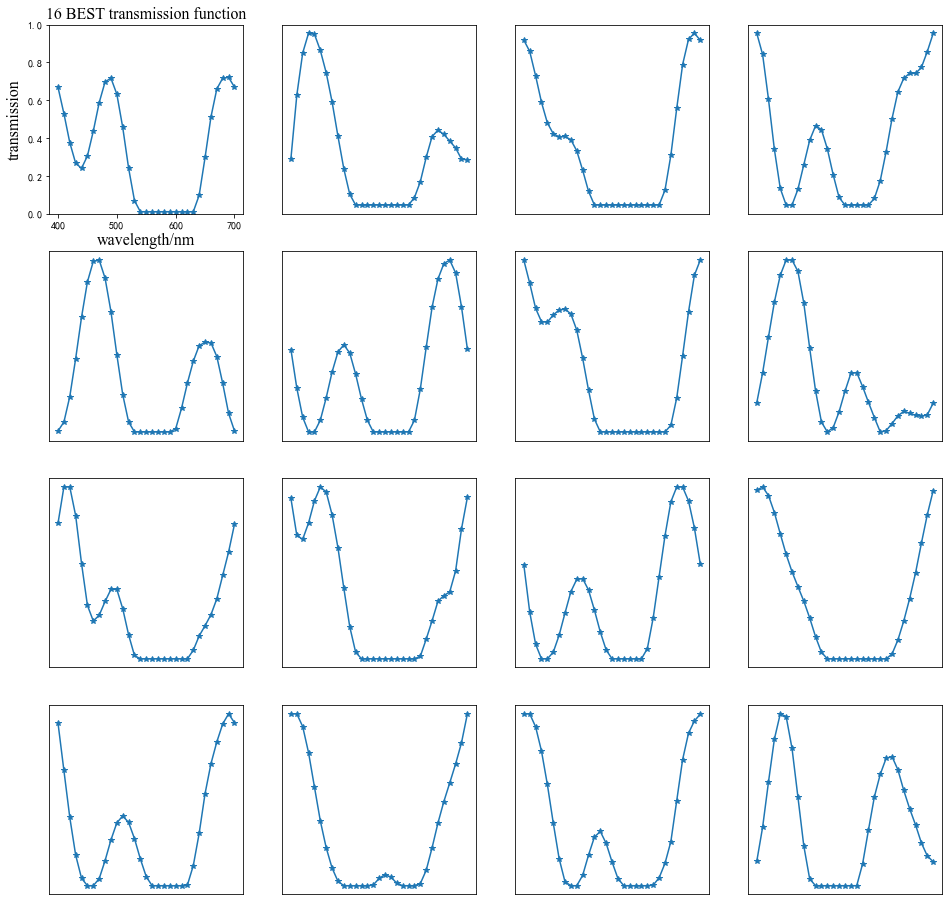

In [16]:
font =  {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}
plt.figure(figsize=(16,16))

filter_T = hybnet.show_BESTFs_T().to('cpu').detach().numpy()
for j in range(TFNum):
    plt.subplot(int(TFNum**0.5),int(TFNum**0.5),j+1)
    plt.plot(WL,filter_T[:,j],'-*')
    
    if j==0:
        plt.ylim(0,1)
        plt.title("%d BEST transmission function"%(TFNum),font)
        plt.xlabel('wavelength/nm',font)
        plt.ylabel('transmission',font)
    else:
        plt.yticks(())
        plt.xticks(())
plt.savefig(path+'%d个随机滤波片的透过率函数onlyICVL_newNet.png'%(TFNum))
plt.show()

In [17]:
print(filter_T.max(),filter_T.min())

0.9899952 0.00993961


time_end = time.time()
time_total = time_end - time_start
m, s = divmod(time_total, 60)
h, m = divmod(m, 60)
print('Training time: %.0fs (%dh%02dm%02ds)' % (time_total, h, m, s))
print('Training time: %.0fs (%dh%02dm%02ds)' % (time_total, h, m, s), file=log_file)
# 
#Camera_response = hybnet.show_camera_weights().detach().cpu().numpy()# 获取

scio.savemat(path + 'camera_informations.mat', mdict={'QE':np.array(Specs_filter.cpu()),'TFnum':TFNum,'K':K,'tc':tc,'h':h_p,'c':c_light,'pixel_S':pixel_S,'hybnet_size':hybnet_size,'thick_min':np.array(thick_min),'thick_max':np.array(thick_max),'beta_range':beta_range,'designed_TF_BESTFs':np.array(hybnet.show_BESTFs().detach().cpu())})
log_file.close()